# Import Library

In [1]:
import os
import re
import json
import xml.etree.ElementTree as ET
from pathlib import Path

import pandas as pd
import numpy as np

# Functions

In [2]:
def get_namespace(element):
    m = re.match(r'\{.*\}', element.tag)
    if m:
        tag = m.group(0)
    else:
        tag = ''
    return  tag

In [3]:
def parse_data(root):
    list_records = list()
    xml_nms = get_namespace(root)

    list_elems = root.findall(f'{xml_nms}logitem')
    n_all_elems = len(list_elems)
    nth_percent_display = n_all_elems // 10

    xml_tag_mapper = {
        f'{xml_nms}id': 'log_id',
        f'{xml_nms}timestamp': 'log_timestamp',
        f'{xml_nms}contributor/{xml_nms}username': 'user_name',
        f'{xml_nms}contributor/{xml_nms}id': 'user_id',
        f'{xml_nms}comment': 'user_comment',
        f'{xml_nms}type': 'action_type',
        f'{xml_nms}action': 'action',
        f'{xml_nms}logtitle': 'log_title'
    }

    for i, elem in enumerate(list_elems):
        record = dict()

        for xml_tag, col_name in xml_tag_mapper.items():
            try:
                value = elem.find(xml_tag).text
            except AttributeError:
                value = None
            
            record[col_name] = value

        list_records.append(record)

        if i % nth_percent_display == 0:
            progress = int(i / nth_percent_display)
            if progress <= 9 and progress > 0:
                print("progress: {}% {}".format(10 * progress, "." * progress))
            else:
                if i == 10:
                    print("done")

    df = pd.read_json(json.dumps(list_records), orient='records')

    return df

# Import Data

In [4]:
path = Path(os.getcwd())

project_dir = path.parent

raw_data_dir = project_dir / 'data' / 'raw'
interim_data_dir = project_dir / 'data' / 'interim'

In [5]:
tree_page_logging = ET.parse(raw_data_dir / 'thwiki-20240920-pages-logging.xml')
root_page_logging = tree_page_logging.getroot()

In [6]:
df_user_log = parse_data(root=root_page_logging)

progress: 10% .
progress: 20% ..
progress: 30% ...
progress: 40% ....
progress: 50% .....
progress: 60% ......
progress: 70% .......
progress: 80% ........
progress: 90% .........


C:\Users\11413929\AppData\Local\Temp\ipykernel_20588\2690832593.py:41: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(list_records), orient='records')


In [7]:
df_user_log.head(3)

,log_id,log_timestamp,user_name,user_id,user_comment,action_type,action,log_title
0,1,2004-12-23T07:51:14Z,Dr.Akarat,174.0,ชาวไอนุ บนเกาะฮอกไกโด ประเทศญี่ปุ่น เมื่อ ค.ศ....,upload,upload,ไฟล์:AinuGroup.jpg
1,2,2004-12-23T09:59:44Z,Dr.Akarat,174.0,เมืองฮาโกดาเตะยามค่ำคืน,upload,upload,ไฟล์:Hakodate.jpg
2,3,2004-12-23T14:54:19Z,Ahoerstemeier,14.0,เนื้อหาเดิม: 'วิวัฒนาการของระบบปฏิบัติการ Linux',delete,delete,รายชื่อระบบปฏิบัติการ


In [8]:
# optional : save log data to 'interim' folder
interim_data_dir.mkdir(parents=True, exist_ok=True)

df_user_log.to_csv(interim_data_dir / "user_log.csv", index=False)

# Exploratory Data Analysis

## Exploring Action Type

In [7]:
df_user_log.action_type.unique()

array(['upload', 'delete', 'block', 'rights', 'move', 'renameuser',
       'protect', 'newusers', 'patrol', 'thanks', 'massmessage', 'merge',
       'create', 'contentmodel', 'gblblock', 'managetags', 'tag',
       'growthexperiments'], dtype=object)

From list of action types, there are 2 action types which could be indicated as a threat to Wikipedia community: <code>'block'</code>, <code>'gblblock'</code>

## Drill down into each Action + comments

In [8]:
df_user_log.loc[df_user_log['action_type'].isin(['block', 'gblblock']), 'action'].unique()

array(['block', 'unblock', 'reblock', 'whitelist', 'gblock2'],
      dtype=object)

When drill down into all actions in these 2 action types, we can see some actions which might not related to bad user behaviors: <code>'unblock'</code>, <code>'whitelist'</code>

In [9]:
df_user_log.loc[df_user_log['action'] == 'unblock', 'user_comment'].unique()[:30]

array(['unblock test', None, 'ป้องกันสร้างบทความแล้ว',
       'รุ่นเก่าหยุดทำงานแล้ว', 'บล็อกผิด', 'ไม่มีปัญหา หรือแก้ไขแล้ว',
       'เปิดโอกาสให้มาเล่น ถึงเวลา 22.00 น.', 'เพื่อปรับระดับการบล็อก',
       '[[แม่แบบ:บล็อกผู้ก่อกวน]]  ใช้ได้ผลดี',
       'ทดสอบแล้ว ไม่เห็นจะต่างจากการบล็อกปกติตรงไหนเลย???',
       'ลดเหลือ 30 นาที', 'ลองอัปเดตโค้ดไปรุ่นใหม่แล้ว',
       'อาจเกิดการบล็อกพลาด', 'เปลี่ยนระยะเวลา เดี๋ยวขาดใจตายเสียก่อน',
       'น่าจะบล็อกผิด', 'อาจเป็นการบล็อกผิดพลาด', 'ไม่ได้ก่อกวน',
       'เหมือนระบบมีปัญหา พ่วงตัวอื่นด้วย', 'อาจเกิดผิดพลาด', 'ผิดพลาด',
       'อาจเกิดความผิดพลาด (ใส่แค่ลิงก์ข้ามภาษา)', 'บล็อกโดยบอตผิดพลาด',
       'อาจเกิดความผิดพลาด', 'ไม่ใช่การก่อกวน', 'IP นี้ใช้หลายที่ในจุฬาฯ',
       'มีเรื่องกับบอตครับ', 'bot ผิดพลาด',
       'ต้องการลบหน้าอย่างผิดวิธี เป็นครั้งแรก', 'บอตผิด', 'บอตพลาด'],
      dtype=object)

For <code>'unblock'</code> type of action, some comments are related to misunderstandings and system error.

In [10]:
df_user_log.loc[df_user_log['action'] == 'whitelist', 'user_comment'].unique()[:20]

array(['Botkung affected', 'prevent collateral damage', 'ใช้โดยบอตคุง'],
      dtype=object)

In [11]:
print("number of records: {}".format(df_user_log.loc[df_user_log['action'] == 'whitelist', :].shape[0]))

number of records: 6


For <code>'whitelist'</code> type of action, available information are not significant (and all comments are related to bot usage, not related to bead behaviors).

In [12]:
df_user_log.loc[df_user_log['action'].isin(('block', 'reblock')), 'user_comment'].unique()[:30]

array(['obscene words', 'spam', 'use obscene word', 'vandal',
       'repeat nonsense edit', 'เขียนเนื้อหาผิดนโยบายของวิกิพีเดีย', None,
       'ผิดนโยบาย', 'testing bug?', 'testing bug', 'block test',
       'ก่อกวนบ่อยครั้ง', 'ป่วน และ อาจก่อให้เกิดการขัดแย้ง',
       'repeat spam', 'vandalism',
       'ก่อกวน 3 บทความ [[ฮิวงะ ฮินาตะ]], ฯลฯ', 'ก่อกวน',
       'ก่อกวนซ้ำหลังจากแจ้งเตือนแล้ว', 'Impersonating', 'กันการแอบอ้าง',
       'อัปโหลดภาพที่ไม่เกี่ยว (หลังจากมีการเตือน)', 'spammer',
       'โฆษณาเว็บไม่เหมาะสม', 'ป่วน',
       'ก่อกวน *** ON WHEELS!!!!!!!!!!!!!!',
       'Willy on Wheels - needs indefinite block', 'โฆษณา', 'spam sites',
       '3RR violation', 'spam รอบ 3'], dtype=object)

For <code>'block'</code> & <code>'reblock'</code> type of action, obviously, all sample comments are related to all the troubles caused by users, such as disturbance, spam, offensive words, posting promotions, etc.

In [13]:
df_user_log.loc[df_user_log['action'].isin(('gblock2', )), :]

,log_id,log_timestamp,user_name,user_id,user_comment,action_type,action,log_title
1277713,1379999,2022-02-19T10:03:45Z,Maintenance script,230668.0,[[m:NOP|Open proxy]]: See the [[m:WM:OP/H|help...,gblblock,gblock2,ผู้ใช้:178.48.120.20
1277716,1380002,2022-02-19T10:05:03Z,Maintenance script,230668.0,[[m:NOP|Open proxy]]: See the [[m:WM:OP/H|help...,gblblock,gblock2,ผู้ใช้:49.36.230.64
1277726,1380012,2022-02-19T10:08:41Z,Maintenance script,230668.0,[[m:NOP|Open proxy]]: See the [[m:WM:OP/H|help...,gblblock,gblock2,ผู้ใช้:178.168.42.198


Finally, <code>'gblock2'</code> type of action are not related.

## Exploring behavior of blocked users

In [14]:
df_user_log['log_timestamp'] = df_user_log['log_timestamp'].str.replace('T', ' ')
df_user_log['log_timestamp'] = df_user_log['log_timestamp'].str.replace('Z', '')

df_user_log['log_timestamp'] = pd.to_datetime(df_user_log['log_timestamp'])

In [27]:
list_blocked_user_id = df_user_log.loc[df_user_log['action_type'].isin(('block', 'reblock')), 'user_id'].unique().tolist()

df_user_blocked = df_user_log.loc[df_user_log['user_id'].isin(list_blocked_user_id), :].copy()

In [28]:
print("number of users created within log period: ", df_user_blocked.loc[df_user_blocked.action.eq('newusers'), 'user_id'].nunique())
print("number of all users existed in log :", df_user_blocked.loc[:, 'user_id'].nunique())

number of users created within log period:  5
number of all users existed in log : 48


Only 5 bad users registered within log period -> keep all user

In [29]:
df_user_blocked['block_timestamp'] = pd.to_datetime(np.where(df_user_blocked['action_type'].isin(('block', 'reblock')), df_user_blocked['log_timestamp'].copy(), pd.NaT))
df_user_blocked.sort_values(by=['user_id', 'log_timestamp'], inplace=True)
df_user_blocked['block_timestamp'] = df_user_blocked.groupby('user_id')['block_timestamp'].bfill()

df_user_blocked['block_date'] = df_user_blocked['block_timestamp'].dt.date
df_user_blocked['log_date'] = df_user_blocked['log_timestamp'].dt.date

df_user_blocked['block_date'] = pd.to_datetime(df_user_blocked['block_date'])
df_user_blocked['log_date'] = pd.to_datetime(df_user_blocked['log_date'])

df_user_blocked.loc[df_user_blocked['action_type'].isin(('block', 'reblock')), 'log_date'] = pd.NaT

### Frequency of user blocking

In [69]:
df_user_blocked.loc[df_user_blocked['action_type'].isin(('block', 'reblock')), :].groupby('user_name').size().describe()

count      48.000000
mean      306.833333
std       709.108200
min         1.000000
25%         2.750000
50%        22.500000
75%       262.000000
max      4002.000000
dtype: float64

We can see that the frequency of user blocking by each particular user is ranging <b>from 1 to 4000 times</b>

<Axes: xlabel='user_name'>

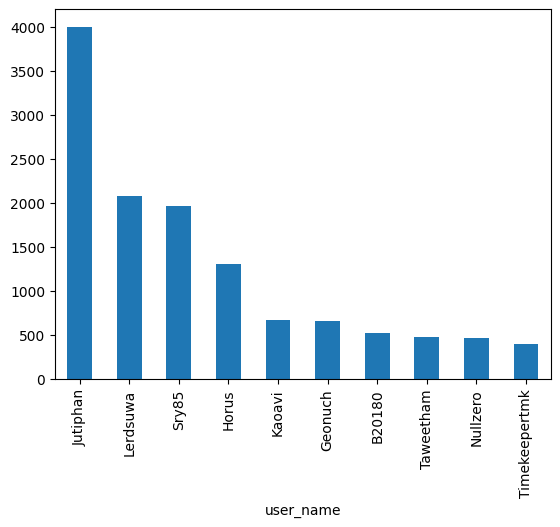

In [68]:
df_user_blocked.loc[df_user_blocked['action_type'].isin(('block', 'reblock')), :].groupby('user_name').size().sort_values(ascending=False).head(10).plot.bar()

These are example of bad users which repeatedly getting blocked by other users.

### Recency of user blocking

In [41]:
df_recency = df_user_blocked.groupby(['user_name', 'block_date'])['log_date'].min().reset_index()
date_diff = df_recency['block_date'] - df_recency['log_date']
diff_in_days = date_diff.dt.days
df_recency['day_diff'] = diff_in_days

In [43]:
df_recency['day_diff'].describe()

count    6335.000000
mean       19.494081
std       171.209693
min         0.000000
25%         1.000000
50%         1.000000
75%         5.000000
max      5746.000000
Name: day_diff, dtype: float64

We can see that 
- there are multiple user blocking within the same day (<code>day_diff=0</code>)
- there are some outliers on recency values (<code>day_diff=5746</code>) -> 15 years approx.

In [60]:
print(f"90% : {df_recency['day_diff'].quantile(.9)}")
print(f"95% : {df_recency['day_diff'].quantile(.95)}")

90% : 16.0
95% : 39.0


Since 95% percentile of recency is around 1-mounth period, we will use <b>95% percentile</b> as a cut off

In [ ]:
percentile_95th = df_recency['day_diff'].quantile(.95)

<Axes: >

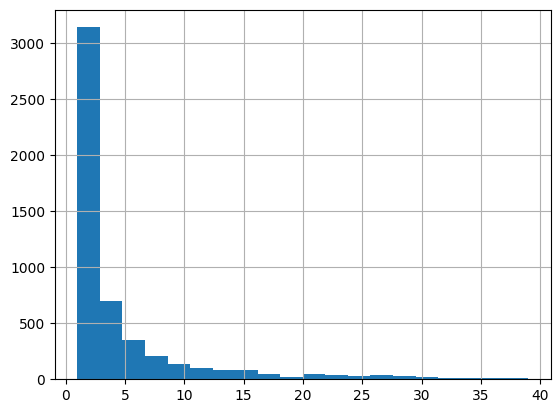

In [62]:
df_recency.loc[df_recency['day_diff'].le(percentile_95th) & df_recency['day_diff'].gt(0), 'day_diff'].hist(bins=20)

In [61]:
df_recency.loc[df_recency['day_diff'].le(percentile_95th) & df_recency['day_diff'].gt(0), 'day_diff'].describe()

count    5115.000000
mean        4.379472
std         6.311935
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        39.000000
Name: day_diff, dtype: float64

After removing outliers by filter out outliers and exclude recency of same-day user blocking (<code>day_diff=0</code>) => we get the average recency of 4 days
> Meaning that, in average, it will take around <b>4 days</b> for bad users to get blocked by other users.

# Proposed Solution

<u><b>Solution</b></u> : ML solution that proactively detect <b>bad user behaviors</b> which might occurs in next n days considering the previous usage behavior, blocking history, and so on.

<u><b>Data</b></u> : log usage level (aggregated previous usage by determined time frame)
 - Calculate log usage features using data up to <b>previous 2 days</b>
 - Define "future bad user behavior" as getting blocked by other users <b>>= 3 times</b>
 - Classify whether the user will get block request within the <b>next 2 days</b> or not (cross-check with <code>'unblock'</code> status for any mistakes on blocking or high block count)

<u><b>Who use this</b></u> : Web admin / admin users / system

<u><b>How to use it</b></u> : Use the solution to automatically suspend users from causing damage to the website